In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Data load

1. Data for our 10 companies selected in first class - to avoid confusion - read it from fixed Excel file

In [3]:
data = pd.read_excel("Data_G2.xlsx")
# Date has dormat 29.12.2000 - bo stara tak ma w tym swoim Excelu, więc eby się zgadzało
data['Date'] = pd.to_datetime(data['Date'].astype('string'), format='%d.%m.%Y')
data.set_index('Date', inplace=True)
data.index = data.index.to_period('m')
# we will work on return data - conversion
data = data.pct_change()
data.head()

,CAT,F,INTC,JPM,MKC,MSFT,NKE,UPS,WMT,XOM
Date,,,,,,,,,,
2000-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01,-0.065363,0.202773,0.230769,0.210234,0.010745,0.407781,-0.014379,0.053617,0.069176,-0.032063
2001-02,-0.059249,-0.013480,-0.228041,-0.151482,0.078189,-0.033777,-0.290493,-0.086753,-0.118134,-0.036839
2001-03,0.066827,0.011147,-0.078775,-0.037720,0.068448,-0.073093,0.033820,0.006545,0.008185,-0.000617
2001-04,0.131140,0.048364,0.174727,0.068597,-0.064063,0.238857,0.036183,0.009666,0.024554,0.093827


2. Fama-French Factors data, from downloaded Excel file
3. MOM factor data from separate Excel file

We join these to to facilitate analysis

In [4]:
def process_factors(df):
    """
    Factors from Fama-French website are always given in the same format (i.e. Date column and values in plain percentages),
    so we write a function to reuse here and possibly later when dealing with F-F 5 factor model.
    This outputs monthly data.
    """
    df['Date'] = pd.to_datetime(df['Date'].astype('string'), format='%Y%m')
    df.set_index('Date', inplace=True)
    df.index = df.index.to_period('m')
    # Values given in CSV are plain percentages - division by 100
    df = df.divide(100)

    return df

In [5]:
fama = process_factors(pd.read_excel('data_class5.xlsx', sheet_name= 'SMB'))
mom = process_factors(pd.read_excel('data_class5.xlsx', sheet_name= 'MOM'))

factors = pd.merge(fama,mom, how='left', left_index=True, right_index=True)
factors

,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
1926-07,0.0296,-0.0256,-0.0243,0.0022,NaN
1926-08,0.0264,-0.0117,0.0382,0.0025,NaN
1926-09,0.0036,-0.0140,0.0013,0.0023,NaN
1926-10,-0.0324,-0.0009,0.0070,0.0032,NaN
1926-11,0.0253,-0.0010,-0.0051,0.0031,NaN
...,...,...,...,...,...
2022-05,-0.0034,-0.0185,0.0841,0.0003,0.0248
2022-06,-0.0843,0.0209,-0.0597,0.0006,0.0079
2022-07,0.0957,0.0281,-0.0410,0.0008,-0.0396


### Pre-process data
* Join data sources
* calculate market excess return (`reM`) and Stock excess return (`<stock name>_re`)

In [6]:
# Join 
dffull = pd.merge(data, factors, how='left', left_index=True, right_index=True)
# drop first NULL row which is causing regression to fail
dffull = dffull.dropna()

# Calculate excess stock return for each company
companies = dffull.columns.tolist()[:10] 
for i in companies:
    dffull[i+'_re'] = dffull[i]-dffull['RF']
# Calculate excess Market return
dffull['reM'] = dffull['Mkt-RF']-dffull['RF']

In [7]:
# Adding PORTFOLIO excess return 
# Equally weighted portfolio here
dffull["portfolio_re"] = dffull.loc[:, companies].mean(axis=1) - dffull['RF']

# in future it might be required to add weighted average below

## TS regressions

#### Regress Excess Stock returns (`<stock name>_re`) on Excess Market returns (`reM`)
* intercept is the Alpha 
* coefficient for reM is the company's Beta (CAPM)
* coefficients in more complex models are also considered in output


In [8]:
def reg_it(df:pd.DataFrame, cols:list, factors:list):
    # Exog variable is constant - it's always Excess Market return
    X = sm.add_constant(df[factors])
    # Store results in dict
    reg_results = {}
    for stock in cols:
        y = df[stock]
        reg_model = sm.OLS(y, X).fit(cov_type='HC3')

        model_params = {
            "R2adj" : reg_model.rsquared_adj,
            "AVG_excess_return" : y.mean(), 
            "alpha" : reg_model.params[0], # In Excel it's in %, but I'd rather keep it as fraction here for further calculations
            **{"B_"+i:reg_model.params[i] for i in factors}, # gets Beta for each factor concerned
            **{"pv(B_"+i+")":reg_model.pvalues[i] for i in factors},
        }
        reg_results[stock[:-3]] = model_params

    results_df = pd.DataFrame.from_dict(reg_results, orient='index')
    # Save it to .csv in our folder (you can copy from this output dataframe and paste to excel directly tough...)
    # results_df.to_csv('Q1_results.csv', sep=';')
    return results_df



## CS regression

#### Regress Average Excess Stock returns on estimated market Beta(s) for each stock
* we obtain lambda_0 (constant) and lambda_1 (price of risk) in CAPM
* lambdas for models with more factors are also considered here


In [9]:
def reg_cs(df:pd.DataFrame, factors):
    y = df['AVG_excess_return']
    X = sm.add_constant(df[factors])
    SML_model = sm.OLS(y, X).fit(cov_type='HC3')
    res = {
        "lambda_0" : SML_model.params[0],
        "pv(lambda_0)" : SML_model.pvalues[0],
        **{"lambda_"+i:SML_model.params[i] for i in factors},
        **{"pv(lambda_"+i+")":SML_model.pvalues[i] for i in factors},
        "R2_adj" : SML_model.rsquared_adj,
        "num_obs" : len(X),
    }
  
    return res


## Analysis and models comparison - Question 1 & 2

* Here TS and CS regressions are cnducted for each model (copy results from output to Excel)


In [10]:
# TODO Additional dict in dict to access each model results_df
model_f = {
    "CAPM" : ['reM'],
    "FF3" : ['reM', "SMB", "HML"],
    "Carhart" : ['reM', "SMB", "HML", "MOM"],
}
# select excess returns columns for TS regressions (whole portfolio is included)
companies = [x for x in dffull.columns.tolist() if '_re' in x]

### CAPM model

In [11]:
results_CAPM = reg_it(dffull, companies, model_f["CAPM"])
display(results_CAPM)

sml_CAPM = reg_cs(results_CAPM.iloc[:-1], ["B_"+f for f in model_f["CAPM"]])
sml_CAPM

,R2adj,AVG_excess_return,alpha,B_reM,pv(B_reM)
CAT,0.461642,0.011259,0.004257,1.318228,1.774133e-24
F,0.289176,0.003513,-0.005400,1.678019,2.968538e-08
INTC,0.353397,0.005094,-0.001265,1.197149,1.948114e-21
JPM,0.489124,0.006734,-0.000202,1.305788,2.499594e-25
MKC,0.097466,0.009868,0.008069,0.338575,1.951117e-05
MSFT,0.349710,0.011207,0.006089,0.963456,1.269744e-31
NKE,0.277536,0.013655,0.009598,0.763648,1.986827e-17
UPS,0.327946,0.005042,0.000963,0.768040,1.032605e-15
WMT,0.114213,0.004354,0.002290,0.388600,3.961074e-06
XOM,0.323427,0.000399,-0.003497,0.733508,9.782354e-14


{'lambda_0': 0.007795225145643748,
 'pv(lambda_0)': 0.04173285530640053,
 'lambda_B_reM': -0.0007221373275028279,
 'pv(lambda_B_reM)': 0.8391103865064427,
 'R2_adj': -0.11886624814672864,
 'num_obs': 10}

### Fama-French 3 factor model

In [12]:
results_FF3 = reg_it(dffull, companies, model_f["FF3"])

display(results_FF3)
sml_FF3 = reg_cs(results_FF3.iloc[:-1], ["B_"+f for f in model_f["FF3"]])
sml_FF3

,R2adj,AVG_excess_return,alpha,B_reM,B_SMB,B_HML,pv(B_reM),pv(B_SMB),pv(B_HML)
CAT,0.478589,0.011259,0.004231,1.240857,0.276324,0.367095,3.462931e-23,0.099078,0.086625
F,0.310950,0.003513,-0.005291,1.547253,0.437947,0.703215,3.271985e-09,0.224724,0.055129
INTC,0.380274,0.005094,-0.002046,1.225875,0.048406,-0.566313,4.296622e-20,0.847949,0.000806
JPM,0.571237,0.006734,0.000967,1.260322,-0.063752,0.859692,1.270367e-22,0.716976,0.000006
MKC,0.092596,0.009868,0.008249,0.341914,-0.045990,0.081163,3.333181e-05,0.702910,0.548016
MSFT,0.381747,0.011207,0.005894,1.033532,-0.208601,-0.451157,1.060275e-27,0.367230,0.016549
NKE,0.272090,0.013655,0.009476,0.760903,0.033117,-0.053361,1.144081e-12,0.816242,0.801429
UPS,0.327423,0.005042,0.001200,0.763909,-0.030929,0.149700,9.131921e-14,0.830892,0.406559
WMT,0.163462,0.004354,0.003070,0.487092,-0.494507,-0.060782,2.116924e-08,0.000546,0.686476
XOM,0.340513,0.000399,-0.002980,0.729810,-0.085758,0.299382,3.736613e-14,0.520518,0.036132


{'lambda_0': 0.009747266025256211,
 'pv(lambda_0)': 0.1201342285393046,
 'lambda_B_reM': -0.0022774247066223736,
 'lambda_B_SMB': 0.006009154938467772,
 'lambda_B_HML': -0.00312816085102201,
 'pv(lambda_B_reM)': 0.7478760759778127,
 'pv(lambda_B_SMB)': 0.5896061765052729,
 'pv(lambda_B_HML)': 0.64152807467203,
 'R2_adj': -0.30779837714005676,
 'num_obs': 10}

### Carhart 4 factor model

In [13]:
results_Carhart = reg_it(dffull, companies, model_f["Carhart"])

display(results_Carhart)
sml_Carhart = reg_cs(results_Carhart.iloc[:-1], ["B_"+f for f in model_f["Carhart"]])
sml_Carhart


,R2adj,AVG_excess_return,alpha,B_reM,B_SMB,B_HML,B_MOM,pv(B_reM),pv(B_SMB),pv(B_HML),pv(B_MOM)
CAT,0.476373,0.011259,0.004218,1.242484,0.276802,0.367593,0.003326,2.538951e-18,0.097197,9.541214e-02,0.980661
F,0.402680,0.003513,-0.001541,1.076408,0.299715,0.559074,-0.962883,7.226106e-05,0.342869,8.925365e-02,0.111816
INTC,0.401875,0.005094,-0.000820,1.071915,0.003206,-0.613446,-0.314850,3.993086e-13,0.989152,2.389072e-04,0.047985
JPM,0.636461,0.006734,0.002860,1.022524,-0.133566,0.786894,-0.486300,3.109747e-15,0.353586,5.176586e-07,0.000006
MKC,0.119635,0.009868,0.007514,0.434118,-0.018921,0.109389,0.188557,1.678272e-07,0.876485,3.965029e-01,0.005673
MSFT,0.406649,0.011207,0.006951,0.900789,-0.247573,-0.491794,-0.271462,1.244358e-10,0.229648,2.220491e-02,0.180923
NKE,0.269561,0.013655,0.009341,0.777858,0.038095,-0.048170,0.034673,2.048768e-14,0.791947,8.283057e-01,0.709654
UPS,0.333127,0.005042,0.000715,0.824837,-0.013041,0.168353,0.124600,9.300903e-12,0.927203,3.588262e-01,0.163815
WMT,0.161389,0.004354,0.002898,0.508598,-0.488193,-0.054199,0.043978,3.705310e-07,0.000741,7.311742e-01,0.620855
XOM,0.349708,0.000399,-0.003533,0.799160,-0.065398,0.320613,0.141823,1.030371e-14,0.628658,2.375195e-02,0.068798


{'lambda_0': 0.007561468119275834,
 'pv(lambda_0)': 0.5757023528510231,
 'lambda_B_reM': 0.0005064916729289454,
 'lambda_B_SMB': 0.00521087553484993,
 'lambda_B_HML': -0.00279469095767065,
 'lambda_B_MOM': 0.0026503594524720253,
 'pv(lambda_B_reM)': 0.9747529142181306,
 'pv(lambda_B_SMB)': 0.7434393189402624,
 'pv(lambda_B_HML)': 0.6864353652086157,
 'pv(lambda_B_MOM)': 0.8443591572382217,
 'R2_adj': -0.5301047089419324,
 'num_obs': 10}

## Validation of model predictions - Question 3

* predicted Excess Return = SUM(lambda(i) * beta(i))
* I guess `lambda_0 * alpha` should be also added

### TODO check predictions - they seem too small and negative. Well, lambdas are almost zero in all models so maybe that's why

In [14]:
# CAPM model
results_CAPM['prediction'] = sum(sml_CAPM["lambda_"+f] * results_CAPM[f] for f in ["B_"+f for f in model_f["CAPM"]]) + results_CAPM['alpha']*sml_CAPM['lambda_0']

# FF3 model
results_FF3['prediction'] = sum(sml_FF3["lambda_"+f] * results_FF3[f] for f in ["B_"+f for f in model_f["FF3"]]) + results_FF3['alpha']*sml_FF3['lambda_0']

# Carhart model
results_Carhart['prediction'] = sum(sml_Carhart["lambda_"+f] * results_Carhart[f] for f in ["B_"+f for f in model_f["Carhart"]]) + results_Carhart['alpha']*sml_Carhart['lambda_0']
results_Carhart

,R2adj,AVG_excess_return,alpha,B_reM,B_SMB,B_HML,B_MOM,pv(B_reM),pv(B_SMB),pv(B_HML),pv(B_MOM),prediction
CAT,0.476373,0.011259,0.004218,1.242484,0.276802,0.367593,0.003326,2.538951e-18,0.097197,9.541214e-02,0.980661,0.001085
F,0.402680,0.003513,-0.001541,1.076408,0.299715,0.559074,-0.962883,7.226106e-05,0.342869,8.925365e-02,0.111816,-0.002019
INTC,0.401875,0.005094,-0.000820,1.071915,0.003206,-0.613446,-0.314850,3.993086e-13,0.989152,2.389072e-04,0.047985,0.001433
JPM,0.636461,0.006734,0.002860,1.022524,-0.133566,0.786894,-0.486300,3.109747e-15,0.353586,5.176586e-07,0.000006,-0.003644
MKC,0.119635,0.009868,0.007514,0.434118,-0.018921,0.109389,0.188557,1.678272e-07,0.876485,3.965029e-01,0.005673,0.000372
MSFT,0.406649,0.011207,0.006951,0.900789,-0.247573,-0.491794,-0.271462,1.244358e-10,0.229648,2.220491e-02,0.180923,-0.000126
NKE,0.269561,0.013655,0.009341,0.777858,0.038095,-0.048170,0.034673,2.048768e-14,0.791947,8.283057e-01,0.709654,0.000890
UPS,0.333127,0.005042,0.000715,0.824837,-0.013041,0.168353,0.124600,9.300903e-12,0.927203,3.588262e-01,0.163815,0.000215
WMT,0.161389,0.004354,0.002898,0.508598,-0.488193,-0.054199,0.043978,3.705310e-07,0.000741,7.311742e-01,0.620855,-0.001996
XOM,0.349708,0.000399,-0.003533,0.799160,-0.065398,0.320613,0.141823,1.030371e-14,0.628658,2.375195e-02,0.068798,-0.000483


In [15]:
results_CAPM

,R2adj,AVG_excess_return,alpha,B_reM,pv(B_reM),prediction
CAT,0.461642,0.011259,0.004257,1.318228,1.774133e-24,-0.000919
F,0.289176,0.003513,-0.005400,1.678019,2.968538e-08,-0.001254
INTC,0.353397,0.005094,-0.001265,1.197149,1.948114e-21,-0.000874
JPM,0.489124,0.006734,-0.000202,1.305788,2.499594e-25,-0.000945
MKC,0.097466,0.009868,0.008069,0.338575,1.951117e-05,-0.000182
MSFT,0.349710,0.011207,0.006089,0.963456,1.269744e-31,-0.000648
NKE,0.277536,0.013655,0.009598,0.763648,1.986827e-17,-0.000477
UPS,0.327946,0.005042,0.000963,0.768040,1.032605e-15,-0.000547
WMT,0.114213,0.004354,0.002290,0.388600,3.961074e-06,-0.000263
XOM,0.323427,0.000399,-0.003497,0.733508,9.782354e-14,-0.000557


In [16]:
results_FF3

,R2adj,AVG_excess_return,alpha,B_reM,B_SMB,B_HML,pv(B_reM),pv(B_SMB),pv(B_HML),prediction
CAT,0.478589,0.011259,0.004231,1.240857,0.276324,0.367095,3.462931e-23,0.099078,0.086625,-0.002273
F,0.310950,0.003513,-0.005291,1.547253,0.437947,0.703215,3.271985e-09,0.224724,0.055129,-0.003143
INTC,0.380274,0.005094,-0.002046,1.225875,0.048406,-0.566313,4.296622e-20,0.847949,0.000806,-0.000749
JPM,0.571237,0.006734,0.000967,1.260322,-0.063752,0.859692,1.270367e-22,0.716976,0.000006,-0.005933
MKC,0.092596,0.009868,0.008249,0.341914,-0.045990,0.081163,3.333181e-05,0.702910,0.548016,-0.001229
MSFT,0.381747,0.011207,0.005894,1.033532,-0.208601,-0.451157,1.060275e-27,0.367230,0.016549,-0.002139
NKE,0.272090,0.013655,0.009476,0.760903,0.033117,-0.053361,1.144081e-12,0.816242,0.801429,-0.001275
UPS,0.327423,0.005042,0.001200,0.763909,-0.030929,0.149700,9.131921e-14,0.830892,0.406559,-0.002382
WMT,0.163462,0.004354,0.003070,0.487092,-0.494507,-0.060782,2.116924e-08,0.000546,0.686476,-0.003861
XOM,0.340513,0.000399,-0.002980,0.729810,-0.085758,0.299382,3.736613e-14,0.520518,0.036132,-0.003143


### Plotting
Prepare scatter plot where you plot:
* on X axix you plot realized excess returns
* on Y axix you plot the predicted excess returns according to a specific model
* 45 degree line

Since there are three models, you will need three such scatter plots.

In [19]:
plot_df = pd.DataFrame()
plot_df['avg_re'] = results_FF3['AVG_excess_return']
plot_df['ff3_re'] = results_FF3['prediction']
plot_df['car_re'] = results_Carhart['prediction']
plot_df['capm_re'] = results_CAPM['prediction']

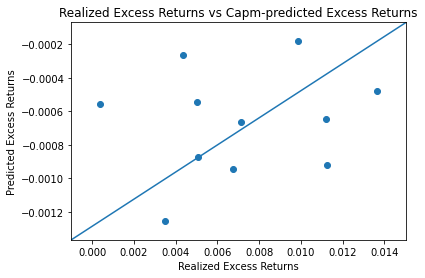

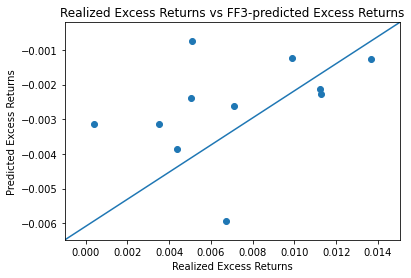

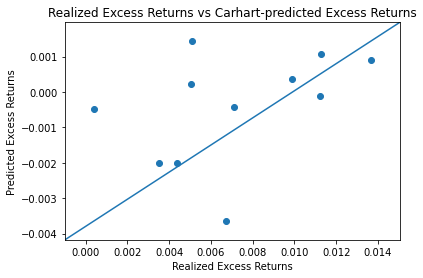

<Figure size 432x288 with 0 Axes>

In [50]:
plt.scatter(plot_df['avg_re'], plot_df['capm_re'])
plt.axline([plt.xlim()[0], plt.ylim()[0]], [plt.xlim()[1], plt.ylim()[1]])
plt.title("Realized Excess Returns vs Capm-predicted Excess Returns")
plt.xlabel("Realized Excess Returns")
plt.ylabel("Predicted Excess Returns")
plt.show()

plt.scatter(plot_df['avg_re'], plot_df['ff3_re'])
plt.axline([plt.xlim()[0], plt.ylim()[0]], [plt.xlim()[1], plt.ylim()[1]])
plt.title("Realized Excess Returns vs FF3-predicted Excess Returns")
plt.xlabel("Realized Excess Returns")
plt.ylabel("Predicted Excess Returns")
plt.show()
plt.savefig("/Users/Maciek/Desktop/Master_Studies/Investment_Theory/ff3.png")

plt.scatter(plot_df['avg_re'], plot_df['car_re'])
plt.axline([plt.xlim()[0], plt.ylim()[0]], [plt.xlim()[1], plt.ylim()[1]])
plt.title("Realized Excess Returns vs Carhart-predicted Excess Returns")
plt.xlabel("Realized Excess Returns")
plt.ylabel("Predicted Excess Returns")
plt.show()
plt.savefig("/Users/Maciek/Desktop/Master_Studies/Investment_Theory/carhart.png")

